## MNISTで多項ロジスティック回帰を学習

### 1. データロード

In [118]:
# ライブラリ
import torch
from sklearn import datasets 
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [119]:
# 1. データロード

dataset = datasets.load_digits()


In [120]:
# 画像データ
images = dataset['images']

# 正解レベル
target = dataset['target']

In [121]:
# データの確認
print('画像データのshape', images.shape)
print('正解ラベルのshape', target.shape)

画像データのshape (1797, 8, 8)
正解ラベルのshape (1797,)


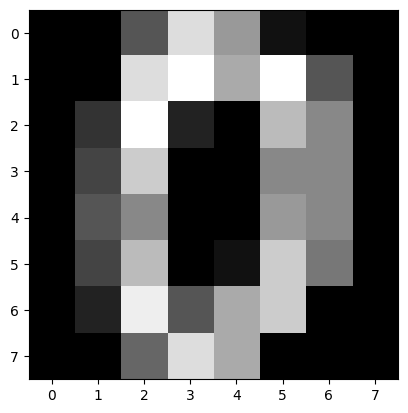

In [122]:
# imageを可視化して確かめる
import matplotlib.pyplot as plt

# 画像を表示するのは, plt.imshow()
# これが1797枚ある
plt.imshow(images[0], cmap='gray')

### 2. 前処理

In [123]:
# ラベルのエンコーディング(one-hotエンコーディング)
import torch.nn.functional as F

# この形ではダメ、なぜなら、numpyの形を取ってはいけない -> tensorの形に！
# あとは、引数にクラスの数を指定, num_classes
# F.one_hot(target)

y_true = F.one_hot(torch.tensor(target), num_classes=10)

# imagesもnumpy arrayなので、tensorにする。また、numpy arrayはfloat64型なので型変換する
# さらに、１次元配列として扱うので8x8 = 64の特徴量として扱うのでshapeを変える。
# 今のshapeはimage.shape -> (1797, 8, 8) -> (1797, 64)にする
images = torch.tensor(images, dtype=torch.float32).reshape(-1, 64)
images = (images - images.mean()) / images.std()

In [124]:
# 学習率の準備
learning_rate = 0.3

# 各イテレーションの損失を入れる
loss_log = []

### 3. パラメータの初期化

In [125]:
# wは10 x 64(出力 x 入力), b = 1 x 10 ( 1 x 出力)
W = torch.rand((10, 64), requires_grad=True)
b = torch.rand((1, 10), requires_grad=True)

### 4. softmaxの実装

In [126]:
# xは行列,
# torch.max(x)はデータごと, 行ごとのmaxを取る。データが3x10だとすると、最大値は3x1にしたい
# 左からrankを0とすると、rankを1とする、
def softmax(x):
    # 分子
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    # 分母
    return e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)



In [127]:
a = torch.rand((3, 5))
a

tensor([[0.2040, 0.2810, 0.1824, 0.8543, 0.3576],
        [0.3684, 0.4519, 0.0455, 0.9556, 0.6813],
        [0.9110, 0.9007, 0.2039, 0.0696, 0.4859]])

In [128]:
# 行ごとの最大値
torch.max(a, dim=-1)

torch.return_types.max(
values=tensor([0.8543, 0.9556, 0.9110]),
indices=tensor([3, 3, 0]))

In [129]:
# 形状を保つ
# これは2つ出力して、値と元のtensorのindexが何かを示している。-> 最大値だけを出力
torch.max(a, dim=-1, keepdim=True)[0]

tensor([[0.8543],
        [0.9556],
        [0.9110]])

In [130]:
# 行ごとにsumを取る
torch.sum(a, dim=-1, keepdim=True)

tensor([[1.8793],
        [2.5027],
        [2.5711]])

In [131]:
torch.exp(a - torch.max(a, dim=-1, keepdim=True)[0])

tensor([[0.5219, 0.5637, 0.5107, 1.0000, 0.6085],
        [0.5559, 0.6043, 0.4025, 1.0000, 0.7601],
        [1.0000, 0.9897, 0.4931, 0.4311, 0.6537]])

In [132]:
# cross entropyの実装
def cross_entropy(y_true, y_pred):
    # sumはスカラー(一つの値)で出力されるので、軸は関係ない
    
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

### 5. for文で学習ループ作成

In [149]:
for epoch in range(5):
    running_loss = 0
    # それぞれのepochではデータを持ってきて、zを計算損失計算、softmax計算
    for i in range(len(target)):
        # 6. 入力データxおよび教師ラベルyを作成
        y_true_ = y_true[i].reshape(-1, 10)  # データ数 x　クラス数
        X = images[i].reshape(-1, 64)  # データ数 x 特徴量

        # 7. z計算
        Z = X@W.T + b

        # 8.softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        # lossはtensorの形なので、.item()を使って数値にする
        loss_log.append(loss.item())
        # epochごとのlossを計算する
        running_loss += loss.item()

        # 10. 勾配を計算する
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失logを出力
    print(f'epoch : {epoch+1}: {running_loss/len(target)}')

epoch : 1: 0.8749518766135855
epoch : 2: 0.4122171392897248
epoch : 3: 0.40823457040378636
epoch : 4: 0.3457045211614563
epoch : 5: 0.2705396815343605


In [150]:
X = torch.tensor(images, dtype=torch.float32)

/tmp/ipykernel_29/1672824624.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


In [151]:
z = X@W.T + b
y_pred = softmax(z)

In [152]:
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]


tensor(0.9572)

In [137]:
# accuracy = 正しく分類できた/全サンプル数


In [138]:
# これだと、1次元の配列になってしまう
# .reshapeにすることで、行列の形にする。 データ数xクラス数
y_true[0].reshape(-1, 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [139]:
# これもデータ数x特徴量にしたいので行列の形にする -> reshape(-1, 64)
images[0].shape

torch.Size([64])

In [140]:
i = 0
y_true_ = y_true[i].reshape(-1, 10)  # データ数 x　クラス数
X = images[i].reshape(-1, 64)  # データ数 x 特徴量

# 7. z計算
z = X@W.T + b

In [141]:
z

tensor([[ 1.5403, -2.9949,  0.0164, -2.6487, -1.1139,  1.1483, -0.8260, -3.5608,
         -0.6175, -1.4660]], grad_fn=<AddBackward0>)

In [142]:
X.shape

torch.Size([1, 64])

In [143]:
W.shape

torch.Size([10, 64])

In [144]:
b.shape

torch.Size([1, 10])

In [145]:
z.shape

torch.Size([1, 10])

In [146]:
y_pred = softmax(z)
loss = cross_entropy(y_true, y_pred)

In [147]:
loss.backward()